# Imports

In [1]:
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy

In [2]:
from Functions import get_quantile_groups, bool_from_index, name_from_index, sigmoid, zscore, get_ages_cols

## Directories etc.

In [3]:
data_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta"
ages_cols = get_ages_cols()
data_save_path = os.path.join(data_path, "all_data")
if not os.path.exists(data_save_path):
    os.makedirs(data_save_path)

## Get data

In [4]:
bf_old = pd.read_csv(os.path.join(data_path, "BUTTERFLY.csv"))
bf_old = bf_old[['id'] +
        ['acc{}'.format(i) for i in range(1, 5)] +
        ['rtavg{}'.format(i) for i in range(1, 5)] +
        ['rtstd{}'.format(i) for i in range(1, 5)] +
        ['A', 'NA', 'B', 'F']]
bf_old = bf_old.rename(columns={'A': 'alpha', 'NA': 'nalpha', 'B': 'beta', 'F': 'forget'})
bf_old = bf_old.rename(columns={'acc{}'.format(i): 'ACC{}'.format(i) for i in range (1, 5)})
bf_old = bf_old.rename(columns={'rtavg{}'.format(i): 'RT{}'.format(i) for i in range (1, 5)})
bf_old = bf_old.rename(columns={'rtstd{}'.format(i): 'RTsd{}'.format(i) for i in range (1, 5)})
for col in ['RT{}'.format(i) for i in range (1, 5)] + ['RTsd{}'.format(i) for i in range (1, 5)]:
    bf_old[col] /= 1000
bf_params = bf_old[['id', 'alpha', 'nalpha', 'beta', 'forget']]
bf_params

,id,alpha,nalpha,beta,forget
0,17,0.18653,0.029147,7.5840,0.133560
1,18,0.18648,0.018240,10.3210,0.032460
2,19,0.32447,0.002878,16.6320,0.011117
3,20,0.20189,0.036424,11.7270,0.038184
4,22,0.16689,0.072827,11.7230,0.070974
...,...,...,...,...,...
270,465,0.18942,0.047580,9.5847,0.057780
271,466,0.29206,0.015143,11.4660,0.120670
272,467,0.21489,0.047446,10.4930,0.084509
273,468,0.21847,0.079979,14.2720,0.141510


BUTTERFLY.csv
NaN indicates missing data
Columns1-8 (A-H): demographic information
-id: subject id
-group: 1 = 8-12 = kid, 2 = 13-17 = teen, 3 = 18-25 = RPP, 4 = 25-30 = adult
-age: age
-sex: 1 = male, 2 = female
-PDS: PDS-T1: T1-T3: T3-T4: T4
Columns 9-12 (I-L): average accuracy per block (total 120 trials, 30 trials per block)
-accX indicates accuracy in block X
Columns13-20 (M-T): average and standard deviation of reaction time per block
-rtavgX: mean RTfor block X
-rtstdX: standarddeviation of RT for block X
Columns 21-24(U-X): fit model parameters for the winning model so far (AABF)
-A:alpha positive (learning rate for positive RPE)
-NA: alpha negative
-B: beta
-F: forgetting

In [5]:
bf = pd.read_csv(os.path.join(data_path, "ButterflyAdditional.csv"))
bf = pd.merge(bf, bf_params, on='id')

# Add 1/beta
bf['1_over_beta'] = 1 / bf['beta']
bf = bf.drop(columns=('beta'))

# Rename columns
bf = bf.rename(columns={'acc{}'.format(i+1): 'ACC_{}'.format(t) for i, t in enumerate(('early', 'mid', 'late'))})
bf = bf.rename(columns={'rt{}'.format(i+1): 'RT_{}'.format(t) for i, t in enumerate(('early', 'mid', 'late'))})
bf = bf.rename(columns={'acc': 'ACC', 'rt': 'RT', 'rt_sd': 'RTsd'})
bf = bf.rename(columns={'ws': 'WS', 'ls': 'LS'})

# Get RTs in seconds
for col in [col for col in bf.columns if 'RT' in col]:
    bf[col] /= 1000
    
# Add "bf_" to each column
bf = bf.rename(columns={col: 'bf_{}'.format(col) for col in bf.columns})
bf

,bf_id,bf_ACC,bf_ACC_early,bf_ACC_mid,bf_ACC_late,bf_RT,bf_RT_early,bf_RT_mid,bf_RT_late,bf_RTsd,bf_stay_choice,bf_stay_motor,bf_WS,bf_LS,bf_miss,bf_alpha,bf_nalpha,bf_forget,bf_1_over_beta
0,17,0.56667,0.650,0.725,0.325,1.33950,1.27260,1.33780,1.47720,0.69630,0.65517,0.34454,0.73846,0.45098,0.0,0.18653,0.029147,0.133560,0.131857
1,18,0.80000,0.575,0.875,0.950,1.19270,1.13960,1.22100,1.19880,0.53170,0.79310,0.52941,0.84615,0.31579,0.0,0.18648,0.018240,0.032460,0.096890
2,19,0.50000,0.500,0.500,0.500,0.83342,0.83970,0.82300,0.83755,0.20657,1.00000,1.00000,1.00000,0.00000,0.0,0.32447,0.002878,0.011117,0.060125
3,20,0.85000,0.675,0.900,0.975,0.99265,1.16290,1.02430,0.84556,0.52117,0.83621,0.54622,0.92683,0.38235,0.0,0.20189,0.036424,0.038184,0.085273
4,22,0.73333,0.600,0.825,0.775,1.51800,1.56260,1.42940,1.57780,1.03220,0.62069,0.44538,0.81081,0.71429,0.0,0.16689,0.072827,0.070974,0.085302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,465,0.74167,0.575,0.800,0.850,1.11640,1.37600,1.06800,0.98635,0.52359,0.65517,0.43697,0.82192,0.62791,0.0,0.18942,0.047580,0.057780,0.104333
271,466,0.60833,0.550,0.700,0.575,0.87618,0.88236,0.97296,0.75243,0.32142,0.75000,0.56303,0.80000,0.31373,0.0,0.29206,0.015143,0.120670,0.087214
272,467,0.80000,0.825,0.800,0.775,1.29200,1.58270,1.08610,1.19510,0.83115,0.71552,0.34454,0.84146,0.58824,0.0,0.21489,0.047446,0.084509,0.095302
273,468,0.71667,0.700,0.775,0.675,2.12680,2.32480,2.46370,1.53470,1.53770,0.57759,0.51261,0.80282,0.77778,0.0,0.21847,0.079979,0.141510,0.070067


In [6]:
fc = pd.read_csv(os.path.join(data_path, "4choice.csv"))

# Wanted columns
fc = fc[['pID', 'pers', 'persER', 'discER', 'revER', 'irrel', 'novel', 'novelER', 'discTTC', 'revTTC', 'trial1visits',
         'cor1visits', 'prerevvisits', 'revvisits', 'revcor1visits', 'lastvisits', 'novelvisits', 'meanRT', 'discRT',
         'revRT', 'stdRT', 'RTvsTOT'] + ['betas_{}'.format(i) for i in range(1, 5)] + ['alpha', 'beta', 'ralpha']]

# Recode errors as accuracy
fc = fc.rename(columns={'persER': 'ACCpers', 'discER': 'ACCdisc', 'novelER': 'ACCnovel'})
for col in ['ACCpers', 'ACCdisc', 'ACCnovel']:
    fc[col] = 1 - fc[col]

# Rename columns
fc = fc.rename(columns={'meanRT': 'RT', 'discRT': 'RTdisc', 'revRT': 'RTrev', 'stdRT': 'RTsd'})
fc = fc.rename(columns={col: 'fc_{}'.format(col) for col in fc.columns})
fc

,fc_pID,fc_pers,fc_ACCpers,fc_ACCdisc,fc_revER,fc_irrel,fc_novel,fc_ACCnovel,fc_discTTC,fc_revTTC,...,fc_RTrev,fc_RTsd,fc_RTvsTOT,fc_betas_1,fc_betas_2,fc_betas_3,fc_betas_4,fc_alpha,fc_beta,fc_ralpha
0,17,1,0.666667,0.320000,0.375000,1,1,0.666667,25,8,...,5.166875,6.252144,19.867000,-0.747755,2.393145,-1.200283,-0.876754,0.003477,0.999985,0.772359
1,18,2,0.333333,1.000000,0.375000,0,1,0.666667,5,8,...,11.596125,3.446076,1.233000,1.024505,0.003234,-0.411955,0.526157,0.518217,0.880084,0.734655
2,19,2,0.333333,0.833333,0.375000,0,1,0.666667,6,8,...,4.342000,5.025114,3.767000,1.152230,0.287367,-0.397495,0.452434,0.705434,0.054487,0.602075
3,20,6,0.538462,0.666667,0.722222,3,4,0.692308,9,18,...,9.277278,4.581754,3.151000,-0.561582,2.062041,-2.808764,0.933507,0.272261,0.041704,0.260541
4,22,1,0.666667,0.555556,0.375000,1,1,0.666667,9,8,...,6.441875,5.563094,0.733000,0.728011,0.921913,-0.387658,0.317687,0.140372,0.295324,0.999997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,485,2,0.500000,0.600000,0.444444,1,1,0.750000,10,9,...,5.018651,1.722870,0.933190,0.668700,0.867902,-0.777079,1.150747,NaN,NaN,NaN
228,486,3,0.571429,0.625000,0.583333,2,2,0.714286,8,12,...,4.111255,3.054055,4.733422,0.281346,1.992270,-2.590093,1.709546,NaN,NaN,NaN
229,487,2,0.333333,0.625000,0.375000,0,1,0.666667,8,8,...,2.416839,1.485993,3.166378,1.385322,-0.207979,2.075924,2.386833,NaN,NaN,NaN
230,488,1,0.500000,0.555556,0.285714,0,1,0.500000,9,7,...,6.062182,4.295897,3.200090,1.217302,1.716272,-1.354100,-1.143206,NaN,NaN,NaN


discER is the error rate (errors/trials) for the discrimination (first) phase. revER is the percentage error rate (errors/trials) for the reversal phase. 

Pers is the number of perseveration errors they made in the reversal phase, while persER is the percentage of total reversal phase errors that were perseveration errors (# perseveration errors/# reversal trials). The same goes for novel and novelER. Irrel is the number of irrelevant errors they made in reversal (so, not picking the novel box, and not perseverating on the correct box from the discrimination phase). 

discTTC is the number of trials they took to reach criterion on the discrimination phase; revTTC is the same in the reversal phase. So irrel + novel + pers should = revTTC. 

Trial1visits is how many different boxes they walk up to on the first trial of the entire task (1st trial of discrimination phase). Cor1visits is how many different boxes they walk up to after they have gotten their first star (so, correctly identified the box that they should continue to pick). 

Prerevvisits is how many boxes they walk up to on the last trial before the reversal. Revvisits is how many boxes they walk up to on the first reversal trial (but before they know that a reversal has even happened). These two numbers should be very similar. 

Revcor1visits is how many boxes they walk up to once they've realized that a reversal has taken place. This should go up a little.

Lastvisits is how many boxes they go up to on the last trial of the task (should be low if they've learned the correct reversal box).  

Novel visits is how many times in TOTAL they approach the completely new box during the reversal phase.

The labels persist for the RT columns: mean RT is self-explanatory, then it's the discrimination RT, then it's the reversal RT, then it's the standard deviation of each subjects' RTs. 

RTvsTOT is a measure of how the RT's changed over the course of the task. So it's the RT from trial 2 versus the RT from the very last trial. Last trial should be faster so the number should be positive, unless the subject is impulsive.

The regression I ran was a logistic regression subject-by-subject, predicting trial-by-trial accuracy (1 or 0). Betas_1 is the effect of cumulative previous correct trials. Betas_2 is the effect of delay since last correct trial. Betas_3 is the effect of reversal, and Betas_4 is the effect of boxes visited on that trial (walked up to but not selected). I ran an iteration with previous INcorrect trials when we found that that had some weird negative effect on accuracy in our other SLCN tasks... But that's the not the version here, I don't think.

Betas_1 through _4 are logistic regression betas with correct/incorrect as the predicted variable and things like previous number of correct trials as predictor. I don't remember now what went into that, but I can clarify if I can see the code again.

alpha is the estimated discrimination phase learning rate from a simple RL model with a separate alpha for the disc and reversal phases. beta is the softmax inverse temperature parameter. ralpha is the separate reversal phase learning rate. Amy will know all about these since I basically just ran her thesis code to obtain these parameters. :) These estimates were obtained in a non-hierarchical fashion, and some of these subjects have only 12 trials, so I wouldn't be too sure about them. I do think Anne ran some hierarchical versions of this modeling, though I don't remember where those numbers went, though I think they were unexciting.

PDS is pubertal development score (which I'm sure you know), Period_age is age of first periods for girls and adult women. Gender is 1 for males, 2 for females. And columbia is the puberty category (1-3) that they would have been assigned to using the criteria Michelle van Tieghem used at Columbia for her 4choice dataset.

In [7]:
rlwm = pd.read_csv(os.path.join(data_path, "RLWM.csv"))
rlwm = rlwm.dropna(subset=['IDs'])

# Sigmoid transform regression results
sig_cols = ['lrn-fix', 'lrn-delay', 'lrn-ns', 'lrn-pcor', 'lrn-pinc']
for col in sig_cols:
    print("Adding column {}_sig.".format(col))
    rlwm[col + '_sig'] = sigmoid(rlwm[col])
rlwm = rlwm.drop(columns=sig_cols)
# (gg.ggplot(rlwm, gg.aes('IDs', 'lrn-fix_sig'))
#  + gg.geom_point(color='red')
#  + gg.geom_smooth(color='red')
#  + gg.geom_point(gg.aes(y='lrn-ns_sig'), color='blue')
#  + gg.geom_smooth(gg.aes(y='lrn-ns_sig'), color='blue')
#  + gg.geom_point(gg.aes(y='lrn-pcor_sig'), color='green')
#  + gg.geom_smooth(gg.aes(y='lrn-pcor_sig'), color='green')
#  + gg.geom_point(gg.aes(y='lrn-pinc_sig'), color='pink')
#  + gg.geom_smooth(gg.aes(y='lrn-pinc_sig'), color='pink')
#  + gg.geom_point(gg.aes(y='lrn-delay_sig'), color='grey')
#  + gg.geom_smooth(gg.aes(y='lrn-delay_sig'), color='grey')
# )

# Add better parameters
# rlwm['1_over_epsilon_beta'] = 1 / rlwm['epsilon']
rlwm['log_alpha'] = np.log(rlwm['RL alpha'])
rlwm['log_nalpha'] = np.log(rlwm['pers'] * rlwm['RL alpha'])

# Rename
rlwm = rlwm.rename(columns={'ns{}-ely'.format(i): 'ACC_early_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-lat'.format(i): 'ACC_late_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-allt'.format(i): 'ACC_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rt_ely'.format(i): 'RT_early_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rt_lat'.format(i): 'RT_late_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rt_allt'.format(i): 'RT_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'ns{}-rtstd_allt'.format(i): 'RTsd_ns{}'.format(i) for i in range(2, 6)})
rlwm = rlwm.rename(columns={'allns-allt': 'ACC', 'allns-ely': 'ACC_early', 'allns-lat': 'ACC_late'})
rlwm = rlwm.rename(columns={'allns-rt_allt': 'RT', 'allns-rt_ely': 'RT_early', 'allns-rt_lat': 'RT_late', 'allns-rtstd_allt': 'RTsd'})
rlwm = rlwm.rename(columns={'allns-motorstay': 'stay_motor', 'allns-choicestay': 'stay_choice', 'allns-WS': 'WS', 'allns-LS': 'LS'})
rlwm = rlwm.rename(columns={'pers': 'persev', 'WM phi': 'forget', 'WM rho': 'rho', 'epsilon': 'epsilon_1_over_beta'})
rlwm = rlwm.rename(columns={'missing': 'miss'})
# print(rlwm.columns)

# # Select columns
# rlwm = rlwm[['IDs', 'lrn-fix_sig', 'lrn-ns_sig', 'lrn-delay_sig', 'lrn-pcor_sig', 'lrn-pinc_sig'] +
#              ['ACC_early_ns{}'.format(i) for i in range(2, 6)] +   # ACC early per set size
#              ['ACC_late_ns{}'.format(i) for i in range(2, 6)] +    # ACC late per set size
#              ['ACC_ns{}'.format(i) for i in range(2, 6)] +         # ACC overall per set size
#              ['ACC', 'ACC_early', 'ACC_late'] +                    # ACC overall overall
#              ['RT_early_ns{}'.format(i) for i in range(2, 6)] +    # RT early per set size
#              ['RT_late_ns{}'.format(i) for i in range(2, 6)] +     # RT late per set size
#              ['RT_ns{}'.format(i) for i in range(2, 6)] +          # RT overall per set size
#              ['RT', 'RT_early', 'RT_late'] +                       # RT overall
#              ['WS', 'LS', 'stay_motor', 'stay_choice', 'RTsd', 'miss'] +
#              ['log_alpha', 'log_nalpha', 'forget', 'rho', 'epsilon_1_over_beta', 'K']#, 'nsslope', 'overall']]
#            ]

# Add columns
rlwm['ACC_ns2_minus_ns5'] = rlwm['ACC_ns2'] - rlwm['ACC_ns5']
rlwm['ACC_ns2_minus_ns5_early'] = rlwm['ACC_early_ns2'] - rlwm['ACC_early_ns5']
rlwm['ACC_ns2_minus_ns5_late'] = rlwm['ACC_late_ns2'] - rlwm['ACC_late_ns5']
rlwm['ACC_ns2_minus_ns5_delta'] = rlwm['ACC_ns2_minus_ns5_late'] - rlwm['ACC_ns2_minus_ns5_early']
rlwm['RT_ns5_minus_ns2'] = rlwm['RT_ns5'] - rlwm['RT_ns2']

rlwm_v02 = pd.read_csv(os.path.join(data_path, "RLWM_v02.csv"))
rlwm_v02 = rlwm_v02.dropna(subset=['IDs'])
rlwm = pd.merge(rlwm, rlwm_v02[['IDs', 'nsslope']], on='IDs')

rlwm = rlwm.rename(columns={col: 'rl_{}'.format(col) for col in rlwm.columns})
rlwm.columns

Adding column lrn-fix_sig.
Adding column lrn-delay_sig.
Adding column lrn-ns_sig.
Adding column lrn-pcor_sig.
Adding column lrn-pinc_sig.


Index(['rl_IDs', 'rl_ACC', 'rl_ACC_early', 'rl_ACC_late', 'rl_ACC_ns2',
       'rl_ACC_early_ns2', 'rl_ACC_late_ns2', 'rl_ACC_ns3', 'rl_ACC_early_ns3',
       'rl_ACC_late_ns3', 'rl_ACC_ns4', 'rl_ACC_early_ns4', 'rl_ACC_late_ns4',
       'rl_ACC_ns5', 'rl_ACC_early_ns5', 'rl_ACC_late_ns5', 'rl_RT',
       'rl_RT_early', 'rl_RT_late', 'rl_RT_ns2', 'rl_RT_early_ns2',
       'rl_RT_late_ns2', 'rl_RT_ns3', 'rl_RT_early_ns3', 'rl_RT_late_ns3',
       'rl_RT_ns4', 'rl_RT_early_ns4', 'rl_RT_late_ns4', 'rl_RT_ns5',
       'rl_RT_early_ns5', 'rl_RT_late_ns5', 'rl_RTsd', 'rl_allns-rtstd_ely',
       'rl_allns-rtstd_lat', 'rl_RTsd_ns2', 'rl_ns2-rtstd_ely',
       'rl_ns2-rtstd_lat', 'rl_RTsd_ns3', 'rl_ns3-rtstd_ely',
       'rl_ns3-rtstd_lat', 'rl_RTsd_ns4', 'rl_ns4-rtstd_ely',
       'rl_ns4-rtstd_lat', 'rl_RTsd_ns5', 'rl_ns5-rtstd_ely',
       'rl_ns5-rtstd_lat', 'rl_stay_motor', 'rl_ns2-motorstay',
       'rl_ns3-motorstay', 'rl_ns4-motorstay', 'rl_ns5-motorstay', 'rl_WS',
       'rl_LS', 'rl_

* Column 1: participant ID. nan if no data
* Columns 2-6 (A-F): logistic regression weights
    * lrn-fix: fixed effect
    * lrn-ns: set size effect
    * lrn-delay: delay effect
    * lrn-pcor: effect of number of previous correct trials
    * lrn-pinc: effect of number of previous incorrect trials
* Columns 7:15 (G-N): proportion of correct trials; nsX indicates set size
    * -ely: early trials (1-3 for each stim)
    * lat: late trials (last three for each stim)
* Columns 16-22 (O-V): correct RT
    * rtavg: mean RT
    * rtstd: std(RT)
    * nsX indicates set size
* Columns 23-28 (W-AB): fit model parameters
    * K capacity
    * RL alpha : learning rate
    * WM rho: WM weight
    * WM phi: forgetting
    * epsilon: noise
    * pers: perseveration

In [8]:
ps = pd.read_csv(os.path.join(data_path, "ProbSwitch.csv"), index_col=0)

# Add 1 / beta columsn
ps['1_over_beta_rl'] = 1 / ps['beta_RL']
ps['1_over_beta_bf'] = 1 / ps['beta_BF']
ps = ps.drop(columns=['calpha', 'cnalpha', 'beta_RL', 'beta_BF'])

ps = ps.rename(columns={'percent_missed': 'miss', 'persev_BF': 'persev_bf', 'persev_RL': 'persev_rl'})
for col in ['RT.{}'.format(i) for i in range(1, 4)] + ['RT', 'RTsd']:
    ps[col] /= 1000
for col in ['RT', 'ACC']:
    ps = ps.rename(columns={'{}.{}'.format(col, i+1): '{}_{}'.format(col, t) for i, t in enumerate(('early', 'mid', 'late'))})
ps = ps.rename(columns={col: 'ps_{}'.format(col) for col in ps.columns})
ps.columns

Index(['ps_sID', 'ps_persev_bf', 'ps_p_switch', 'ps_p_reward', 'ps_alpha',
       'ps_nalpha', 'ps_persev_rl', 'ps_ACC', 'ps_stay', 'ps_WS', 'ps_LS',
       'ps_RTsd', 'ps_RT', 'ps_n_switches', 'ps_ACC_early', 'ps_stay.1',
       'ps_WS.1', 'ps_LS.1', 'ps_RTsd.1', 'ps_RT_early', 'ps_ACC_mid',
       'ps_stay.2', 'ps_WS.2', 'ps_LS.2', 'ps_RTsd.2', 'ps_RT_mid',
       'ps_ACC_late', 'ps_stay.3', 'ps_WS.3', 'ps_LS.3', 'ps_RTsd.3',
       'ps_RT_late', 'ps_miss', 'ps_WLS', 'ps_LWS', 'ps_criterion_trial',
       'ps_1_over_beta_rl', 'ps_1_over_beta_bf'],
      dtype='object')

## Create all_data and all_data_long

In [9]:
bf.shape, fc.shape, rlwm.shape, ps.shape

((275, 19), (232, 29), (243, 86), (291, 38))

In [10]:
bf_ids = np.unique(bf.bf_id)
rl_ids = np.unique(rlwm.rl_IDs)
ps_ids = np.unique(ps.ps_sID)
fc_ids = np.unique(fc.fc_pID)
fc_ids_clean = [id for id in fc.fc_pID if (id < 300) or (id > 400)]

print("Butterfly data (n={}): {}".format(len(bf_ids), bf_ids))
print("RLWM data (n={}): {}".format(len(rl_ids), rl_ids))
print("ProbSwitch data (n={}): {}".format(len(ps_ids), ps_ids))
print("4-choice data (n={}; after excluding Columbia: {}): {}".format(len(fc_ids), len(fc_ids_clean), fc_ids))

Butterfly data (n=275): [ 17  18  19  20  22  23  24  25  27  28  29  30  31  32  35  36  37  38
  40  42  43  44  45  46  48  49  50  51  53  55  56  57  59  60  65  66
  67  68  70  71  72  73  74  76  77  78  80  81  82  83  85  86  87  90
  91  92  93  94  95  96  97  98  99 100 101 102 104 105 106 109 110 111
 112 113 115 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 137 138 139 140 141 142 144 145 147 148 149 150 151 152
 153 154 155 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 174 175 176 177 178 180 181 182 183 184 185 188 189 190 191 193 194
 195 196 198 199 200 201 202 204 205 206 208 209 210 212 213 214 215 217
 218 219 220 221 300 301 302 303 304 305 306 308 309 310 311 312 313 314
 315 316 317 318 319 320 321 322 323 325 326 328 329 330 331 332 333 334
 335 337 338 339 342 343 345 347 348 349 350 351 352 353 354 357 359 360
 361 362 363 364 365 409 410 411 412 413 415 416 417 419 420 421 422 423
 424 426 427 428 429 430 43

In [11]:
# Merge all tasks
bf_rlwm = bf.merge(rlwm, left_on='bf_id', right_on='rl_IDs')  # bf + rlwm
# fc_bf_rlwm = fc.merge(bf_rlwm, left_on='fc_pID', right_on='bf_id')  # + fc
# all_data = fc_bf_rlwm.merge(ps, left_on='fc_pID', right_on='ps_sID')  # + ps
all_data = bf_rlwm.merge(ps, left_on='bf_id', right_on='ps_sID')  # + ps
all_data = all_data.rename(columns={'bf_id': 'ID'})
all_data = all_data.drop(columns=['rl_IDs', 'ps_sID'])

# Add ages data
ages_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
ages = pd.read_csv(os.path.join(ages_dir))
all_data = all_data.merge(ages[ages_cols])
all_data['age_group'], _ = get_quantile_groups(all_data, 'PreciseYrs')

# Add extra columns
for task in ['bf', 'rl', 'ps']:
    all_data['{}_ACC_delta'.format(task)] = all_data['{}_ACC_late'.format(task)] - all_data['{}_ACC_early'.format(task)]
    all_data['{}_RT_delta'.format(task)] = all_data['{}_RT_early'.format(task)] - all_data['{}_RT_late'.format(task)]
    all_data['{}_WS_plus_LS'.format(task)] = all_data['{}_WS'.format(task)] + all_data['{}_LS'.format(task)]

# Confirm
print("Final number of participants: {}".format(all_data.shape[0]))
print("Columns: {}".format(all_data.columns[:70]))
print("Columns: {}".format(all_data.columns[70:]))

Final number of participants: 204
Columns: Index(['ID', 'bf_ACC', 'bf_ACC_early', 'bf_ACC_mid', 'bf_ACC_late', 'bf_RT',
       'bf_RT_early', 'bf_RT_mid', 'bf_RT_late', 'bf_RTsd', 'bf_stay_choice',
       'bf_stay_motor', 'bf_WS', 'bf_LS', 'bf_miss', 'bf_alpha', 'bf_nalpha',
       'bf_forget', 'bf_1_over_beta', 'rl_ACC', 'rl_ACC_early', 'rl_ACC_late',
       'rl_ACC_ns2', 'rl_ACC_early_ns2', 'rl_ACC_late_ns2', 'rl_ACC_ns3',
       'rl_ACC_early_ns3', 'rl_ACC_late_ns3', 'rl_ACC_ns4', 'rl_ACC_early_ns4',
       'rl_ACC_late_ns4', 'rl_ACC_ns5', 'rl_ACC_early_ns5', 'rl_ACC_late_ns5',
       'rl_RT', 'rl_RT_early', 'rl_RT_late', 'rl_RT_ns2', 'rl_RT_early_ns2',
       'rl_RT_late_ns2', 'rl_RT_ns3', 'rl_RT_early_ns3', 'rl_RT_late_ns3',
       'rl_RT_ns4', 'rl_RT_early_ns4', 'rl_RT_late_ns4', 'rl_RT_ns5',
       'rl_RT_early_ns5', 'rl_RT_late_ns5', 'rl_RTsd', 'rl_allns-rtstd_ely',
       'rl_allns-rtstd_lat', 'rl_RTsd_ns2', 'rl_ns2-rtstd_ely',
       'rl_ns2-rtstd_lat', 'rl_RTsd_ns3', 'rl_ns3

In [12]:
# Save all_data to csv
all_data.to_csv(os.path.join(data_save_path, "all_data.csv"))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 20 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


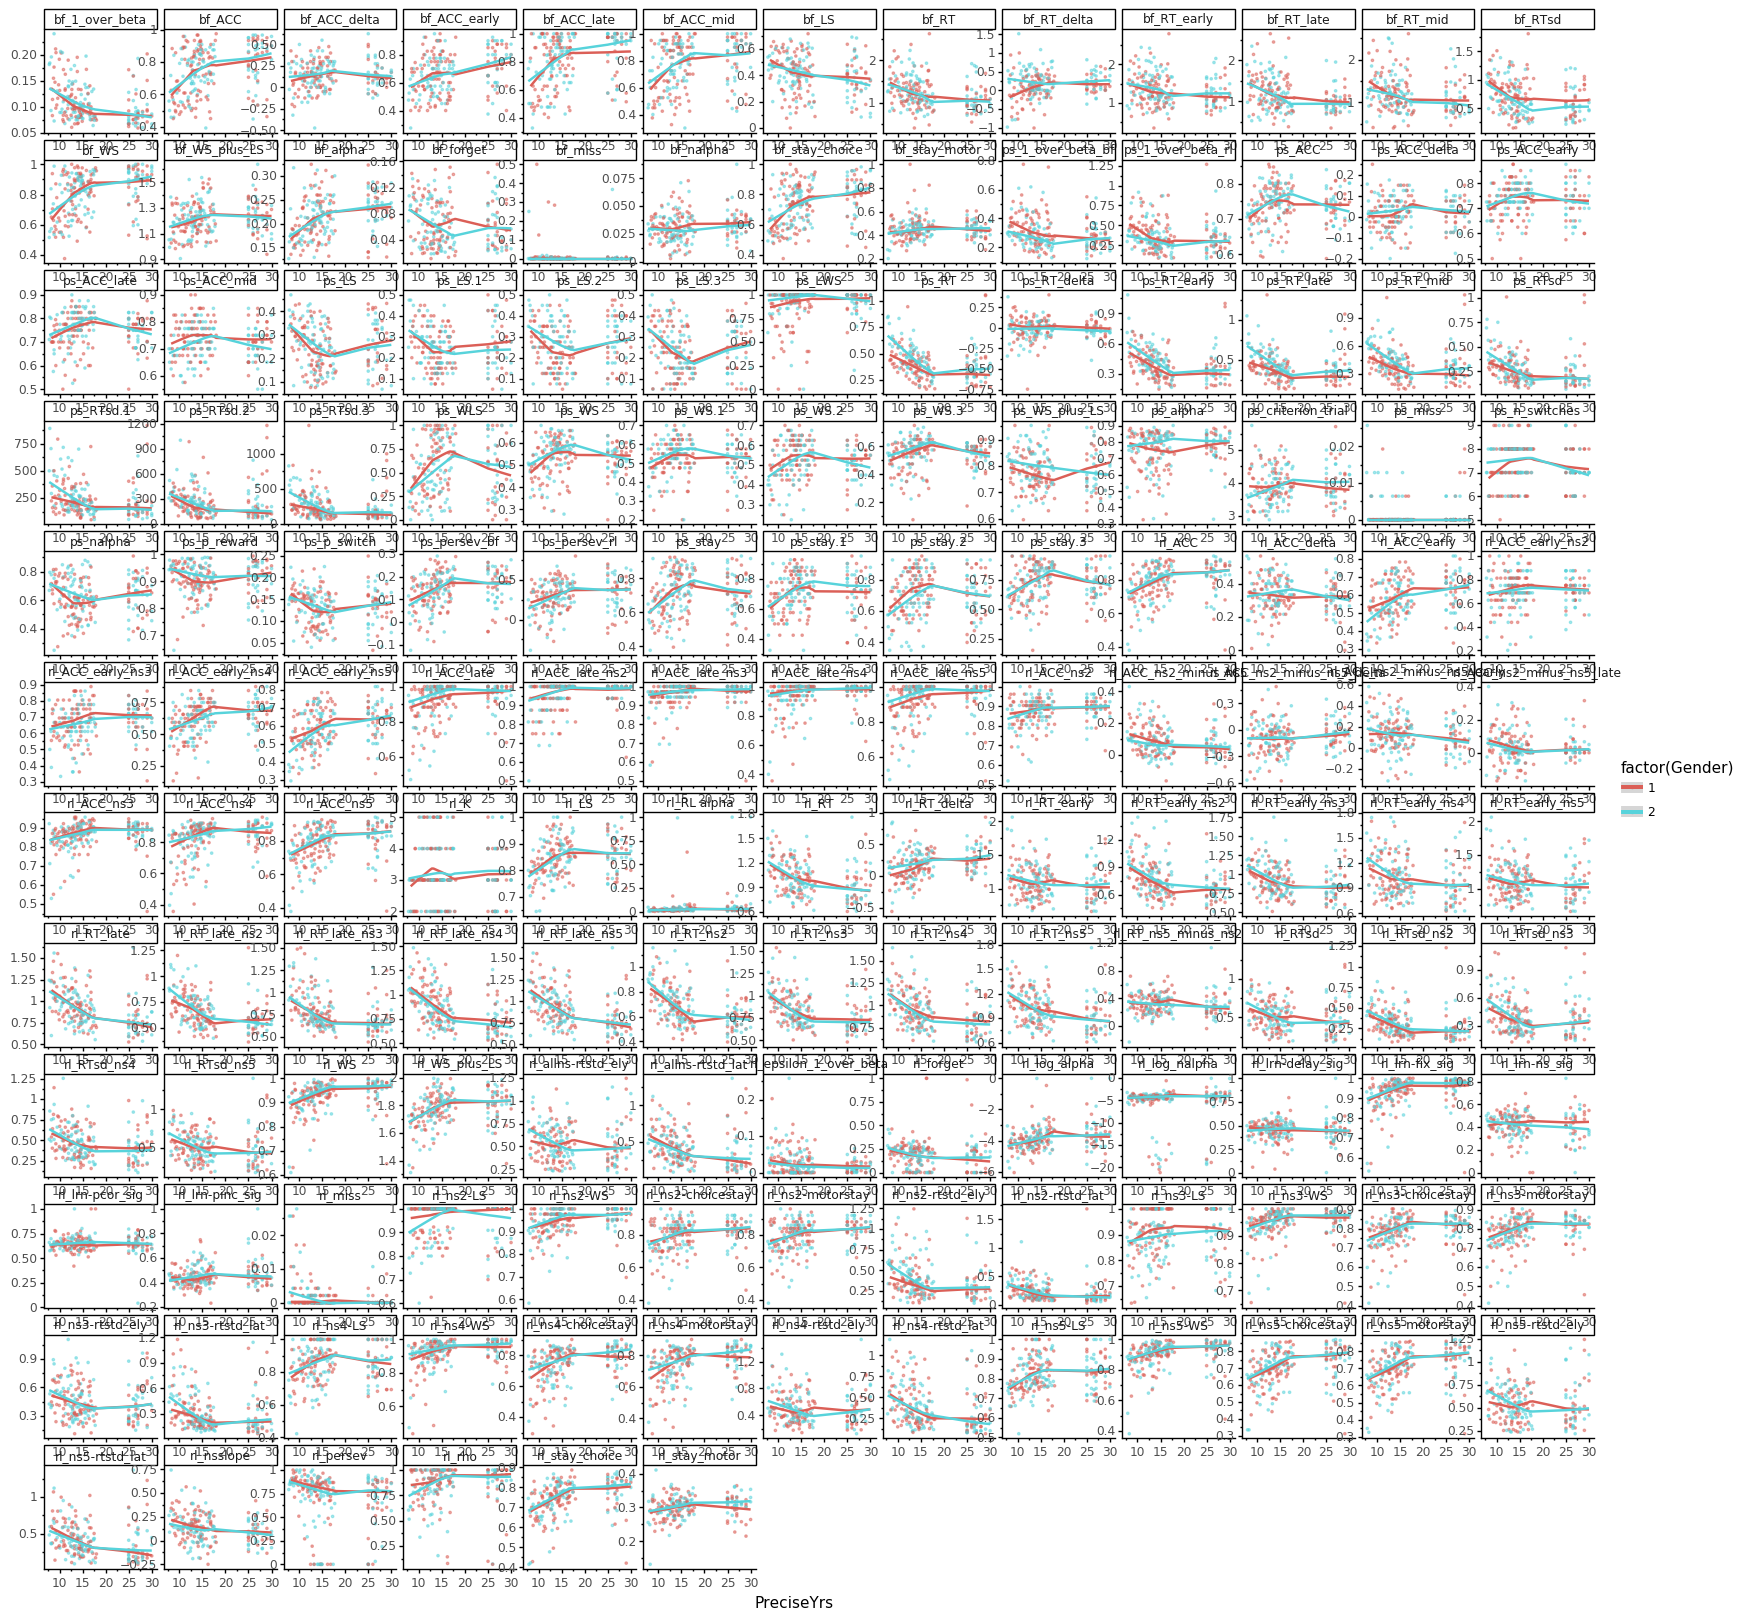

<ggplot: (-9223371907866888658)>

In [13]:
# Check that everything looks good
gg.options.figure_size = (20, 20)
all_data_long = all_data.melt(id_vars=ages_cols+['age_group'], var_name='feature')
g = (gg.ggplot(all_data_long, gg.aes('PreciseYrs', 'value', color='factor(Gender)'))
 + gg.geom_point(size=0.5, alpha=0.5)
 + gg.geom_smooth()
 + gg.labs(y='')
 + gg.facet_wrap('~ feature', scales='free')
)
g